In [1073]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### set the matplotlib font as helvetica and the font style to 42
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['pdf.fonttype'] = 42


### Define some helper functions

In [1396]:
"""
Input is a m x n array of (concepts) x (colors) filled with association ratings
Output is a list of length m with the index of the color that should be associated with each concept
"""
def assignment_solve( ratings,  method="balanced", return_merit=False ):
    m,n = ratings.shape
    assert m <= n, "More concepts than colors, assignment impossible!"
    
    # isolated merit function (only considers target in isolation)
    if method == "isolated":
        merit_matrix = ratings
    
    # balanced merit function (balances ratings of target vs off-target objects with each color)
    elif method == "balanced":
        t = 1  # this is the penalty parameter. t=1 for balanced, t=0 recovers isolated case.
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                # merit_matrix[i,j] = ratings[i,j] - t*ratings[np.arange(m)!=i,j].max()
                merit_matrix[i,j] = ratings[i,j] - t*ratings[np.arange(m)!=i,j].max()
    
    # baseline merit function (uniformly bad assignment)
    elif method == "baseline":
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = -abs( ratings[i,j] - ratings[np.arange(m)!=i,j].max() )
                
    else:
        assert False, "unknown method in assignment problem"
        
    row_ind, col_ind = linear_sum_assignment( merit_matrix, maximize=True )
    if return_merit==True:
        return merit_matrix
    else:
        return col_ind


from itertools import permutations
def get_ordering_ind(row):
    # Select the first four columns of the row
    values = row[['++', '+', '-', '--']].values
    
    # Compute the unique permutations of the values
    unique_permutations =sorted(list(permutations(values)))
    ind = unique_permutations.index(tuple(values))


    
    return ind
    


def make_assignment_plot(df,legend_labels,title,save_name):

    '''
    df: dataframe with the data to plot; should have 17 rows per column with responses for each texture x measurement type combination
    legend_labels: list of labels for the legend
    title: title of the plot
    save_name: name of the file to save the plot to
    
    '''

 ### The groups are the order of how different measurement types are represented in the barplots
    groups = [
        [8,12,16,4],
        [7,11,15,3],
        [6,10,14,2],
        [5,9,13,1]
        ]

    # Calculate the means and standard errors
    means = np.array([df.iloc[:, g].mean() for g in groups])
    sem = np.array([df.iloc[:, g].sem() for g in groups])

    # Set the colors
    colors = ['grey','grey','brown', 'brown']

    # Create the barplot
    fig, ax = plt.subplots(figsize=(10,8))
    width = 0.2
    space_within_group = 0.01
    space_between_group = 0.5
    x = np.arange(len(groups))
    for i, g in enumerate(groups):
        c=0
        for j, col in enumerate(g):
            if j == 1 or j == 2:
                ax.bar(x[i]- (1.5*width + space_within_group) + j*(width + space_within_group), means[i][j], width=width, yerr=sem[i][j], facecolor= 'none', color=colors[j],edgecolor=colors[j], linewidth=2)
            else:
                ax.bar(x[i]+(0.5*width + space_within_group) + (j-2)*(width + space_within_group), means[i][j], width=width, yerr=sem[i][j], facecolor= colors[j],edgecolor=colors[j], linewidth=2)

    # Add labels and title
    ax.set_xticks(x)
    # ax.set_xticklabels(['Group {}'.format(i+1) for i in range(len(groups))])
    ax.set_xticklabels(['--','-','+','++'])
    ax.tick_params(axis='x', labelsize=20)
    ax.set_ylabel('proportion chosen', fontsize=18)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, fontsize=20)
    ax.set_ylim(0,1)
    # Add legend
    ax.legend(legend_labels,  fontsize=15)
    plt.savefig(save_name,bbox_inches='tight',dpi=300)
    plt.close()



def create_assignment_matrix(row):
    values = row[1:].values
    result = [row[0]]
    for i in range(0, 16, 4):
        max_index = np.argmax(values[i:i+4])
        result.extend([1 if j == max_index else 0 for j in range(4)])
    return result
 

def reshape_dataframe(df,row):
    """
    Reshape a pandas DataFrame by taking each row and reshaping the first 16 columns into a 4x4 matrix
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: Reshaped DataFrame
    """
    # Select the first 16 columns
    if row==None:
        df_16 = df.iloc[:, 1:17].mean(axis=0)
    else:
        df_16 = df.iloc[row, 1:17]
    
    # Reshape the data into a 4x4 matrix
    reshaped_data = np.zeros((4, 4))
    reshaped_data[:, 0] = df_16.iloc[ [0, 4, 8, 12]].values.flatten()
    reshaped_data[:, 1] = df_16.iloc[ [1, 5, 9, 13]].values.flatten()
    reshaped_data[:, 2] = df_16.iloc[ [2, 6, 10, 14]].values.flatten()
    reshaped_data[:, 3] = df_16.iloc[ [3, 7, 11, 15]].values.flatten()
    
    # Convert the reshaped data to a DataFrame with appropriate column names and index
    columns = ['++', '+', '-', '--']
    reshaped_df = pd.DataFrame(reshaped_data, columns=columns)
    # reshaped_df['id'] = df['id']
    # reshaped_df.set_index('id', inplace=True).reset_index()
    
    return reshaped_df

def unreshape_dataframe(reshaped_array):
    """
    Convert a reshaped pandas DataFrame back to the original format by reversing the operation performed by the reshape_dataframe() function.
    
    Parameters:
    reshaped_df (pandas.DataFrame): Reshaped DataFrame
    
    Returns:
    list: List of 16 numbers in the original format
    """
    # Reshape the DataFrame back into a 1D array
    data = np.zeros((16,))
    data[0] = reshaped_array[0][0]
    data[1] = reshaped_array[0][1]
    data[2] = reshaped_array[0][2]
    data[3] = reshaped_array[0][3]
    data[4] = reshaped_array[1][0]
    data[5] = reshaped_array[1][1]
    data[6] = reshaped_array[1][2]
    data[7] = reshaped_array[1][3]
    data[8] = reshaped_array[2][0]
    data[9] = reshaped_array[2][1]
    data[10] = reshaped_array[2][2]
    data[11] = reshaped_array[2][3]
    data[12] = reshaped_array[3][0]
    data[13] = reshaped_array[3][1]
    data[14] = reshaped_array[3][2]
    data[15] = reshaped_array[3][3]
    # data = pd.Series(data, index = ['rf_++', 'rf_+', 'rf_-', 'rf_--', 'sf_++', 'sf_+', 'sf_-', 'sf_--',
    #          'so_++', 'so_+', 'so_-', 'so_--', 'ro_++', 'ro_+', 'ro_-', 'ro_--'])
    
    return np.array(data)

from scipy.stats import chisquare
def compute_chisquare(frequency_vector):
    n = sum(frequency_vector)
    expected_freq = [n/(frequency_vector.shape[0])]*frequency_vector.shape[0]

    statistic, pvalue = chisquare(frequency_vector, expected_freq)
    print("Chi-square test statistic:", statistic)
    print("p-value:", pvalue)

In [1238]:
diverging_raw = pd.read_csv('diverging_raw_final.csv') ### read in raw data
diverging_raw.subjectID = diverging_raw.index ### reset subjectID to index

In [1239]:
diverging_raw_opcl = diverging_raw.iloc[:,:33] ### select only open/close data

diverging_raw_hilo = diverging_raw.iloc[:,[0] + list(range(33, 65))] ### select only high/low data

In [1248]:
### ugly df currently but reformat Qualtrics data to look nicer for downstream analysis
response_vecs = []
ids = []
for i, row in diverging_raw_opcl.iterrows():
    for j in range(8):
        this_vec = np.zeros(16)
        trial_responses = row[1+(4*j):1+(4*(j+1))]
        for k,this_response in enumerate(trial_responses):
            
            if this_response == 1:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 2:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 3:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 4:
                this_vec[4*(this_response-1)+k] = 1

        response_vecs.append(this_vec)
        ids.append(row[0])

response_vecs = np.array(response_vecs)
ids = np.array(ids)
response_vecs = np.concatenate((ids.reshape(-1,1),response_vecs),axis=1)
response_df_opcl= pd.DataFrame(response_vecs,columns=['id','rf_++','rf_+','rf_-','rf_--','sf_++','sf_+','sf_-','sf_--','so_++','so_+','so_-','so_--','ro_++','ro_+','ro_-','ro_--'])
response_df_opcl.iloc[:,1:] = response_df_opcl.iloc[:,1:].astype('float32')

        
      
response_vecs = []
ids = []
for i, row in diverging_raw_hilo.iterrows():
    for j in range(8):
        this_vec = np.zeros(16)
        trial_responses = row[1+(4*j):1+(4*(j+1))]
        for k,this_response in enumerate(trial_responses):
            
            if this_response == 1:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 2:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 3:
                this_vec[4*(this_response-1)+k] = 1
            elif  this_response == 4:
                this_vec[4*(this_response-1)+k] = 1

        response_vecs.append(this_vec)
        ids.append(row[0])

response_vecs = np.array(response_vecs)
ids = np.array(ids)
response_vecs = np.concatenate((ids.reshape(-1,1),response_vecs),axis=1)
response_df_hilo= pd.DataFrame(response_vecs,columns=['id','rf_++','rf_+','rf_-','rf_--','sf_++','sf_+','sf_-','sf_--','so_++','so_+','so_-','so_--','ro_++','ro_+','ro_-','ro_--'])
response_df_hilo.iloc[:,1:] = response_df_hilo.iloc[:,1:].astype('float32')

        

In [1249]:
### save out data locally
really_run = False
if really_run:
        
    response_df_hilo.to_csv('response_df_hilo.csv',index=False)
    response_df_opcl.to_csv('response_df_opcl.csv',index=False)

In [1250]:
### create grouped versions of the dataframes and get a peek at one of them
response_df_hilo_grouped = response_df_hilo.groupby('id').mean().reset_index()
response_df_opcl_grouped = response_df_opcl.groupby('id').mean().reset_index()
response_df_opcl_grouped.head()

,id,rf_++,rf_+,rf_-,rf_--,sf_++,sf_+,sf_-,sf_--,so_++,so_+,so_-,so_--,ro_++,ro_+,ro_-,ro_--
0,0.0,0.625,0.25,0.00,0.125,0.125,0.000,0.375,0.500,0.000,0.125,0.500,0.375,0.25,0.625,0.125,0.000
1,1.0,0.500,0.50,0.00,0.000,0.500,0.500,0.000,0.000,0.000,0.000,0.625,0.375,0.00,0.000,0.375,0.625
2,2.0,0.750,0.25,0.00,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.25,0.750,0.000,0.000
3,3.0,0.125,0.00,0.25,0.625,0.750,0.125,0.000,0.125,0.125,0.750,0.125,0.000,0.00,0.125,0.625,0.250
4,4.0,0.000,0.00,0.00,1.000,0.875,0.125,0.000,0.000,0.125,0.875,0.000,0.000,0.00,0.000,1.000,0.000


#### Make average plots

In [1388]:
make_assignment_plot(response_df_opcl_grouped,['SF','SO','RO','RO'],'Open-Close Maps','opcl_avg.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [1389]:
make_assignment_plot(response_df_hilo_grouped,['SH','SL','RL','RH'],'High-Low Maps','hilo_avg.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


#### Make plots for every subject

In [1270]:
for i, row in response_df_hilo_grouped.iterrows():
    make_assignment_plot(pd.DataFrame(row.values.reshape(1,-1)),['SH','SL','RL','RH'],f'High-Low Maps subject {row[0]}',f'subject_level_avg_hilo/hilo_avg_{i}.pdf')
for i, row in response_df_opcl_grouped.iterrows():
    make_assignment_plot(pd.DataFrame(row.values.reshape(1,-1)),['SF','SO','RO','RF'],f'Open-Close Maps  subject {row[0]}',f'subject_level_avg_opcl/opcl_avg_{i}.pdf')

/Users/kushinm/miniforge3/envs/color_projects/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/kushinm/miniforge3/envs/color_projects/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra byte

In [1390]:
### create assignemtn matrix for both matrices and save out locally

response_df_opcl_assign = response_df_opcl_grouped.apply(create_assignment_matrix, axis=1, result_type='expand')
response_df_opcl_assign.columns = ['id','rf_++','rf_+','rf_-','rf_--','sf_++','sf_+','sf_-','sf_--','so_++','so_+','so_-','so_--','ro_++','ro_+','ro_-','ro_--']


response_df_hilo_assign = response_df_hilo_grouped.apply(create_assignment_matrix, axis=1, result_type='expand')
response_df_hilo_assign.columns = ['id','rf_++','rf_+','rf_-','rf_--','sf_++','sf_+','sf_-','sf_--','so_++','so_+','so_-','so_--','ro_++','ro_+','ro_-','ro_--']

really_run = False
if really_run:
    response_df_opcl_assign.to_csv('response_df_opcl_assign.csv',index=False)
    response_df_hilo_assign.to_csv('response_df_hilo_assign.csv',index=False)


In [1391]:
### deprecated cluster plots

In [1394]:
# linked = linkage(response_df_opcl_grouped.iloc[:,1:], method='ward')
# plt.figure(figsize=(6, 8))
# plt.title("Hierarchical Clustering for Open-Close Maps")
# dendrogram(linked,
#            orientation='left',
#            labels = response_df_opcl_grouped.iloc[:,0].values,
#            color_threshold=0,
#            distance_sort='descending',
#            show_leaf_counts=True)

# plt.xlabel("Distance (Ward)")
# plt.savefig('opcl_hierarchical_clustering.pdf',bbox_inches='tight',dpi=300)
# plt.show()

# linked = linkage(response_df_hilo_grouped.iloc[:,1:], method='ward')
# plt.figure(figsize=(6, 8))
# plt.title("Hierarchical Clustering for High-Low Maps")
# dendrogram(linked,
#            orientation='left',
#            labels = response_df_opcl_grouped.iloc[:,0].values,
#            color_threshold=0,
#            distance_sort='descending',
#            show_leaf_counts=True)

# plt.xlabel("Distance (Ward)")
# plt.savefig('hilo_hierarchial.pdf',bbox_inches='tight',dpi=300)
# plt.show()

In [1395]:
grouped_merit_matrix = reshape_dataframe(response_df_opcl_grouped,None)
grouped_assigment = assignment_solve(np.array(grouped_merit_matrix))
assign_inds = np.argsort(grouped_assigment)+1
assignment_matrix = np.zeros((4,4))
assignment_matrix[[0,1,2,3],grouped_assigment]=1

### look at overall assignment matrix on open-close maps
assignment_matrix


array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

### mappings with all the data

rough filled = ++ \
rough open = + \
smooth open = - \
smooth filled = -- 

In [1277]:
assignments =[]
assignment_vecs =[]
for i, row in response_df_opcl_grouped.iterrows():
    this_merit_matrix = reshape_dataframe(response_df_opcl_grouped,i)
    this_assigment = assignment_solve(np.array(this_merit_matrix))
    assign_inds = np.argsort(this_assigment)+1

    assignments.append(assign_inds)
    assignment_matrix = np.zeros((4,4))
    assignment_matrix[[0,1,2,3],this_assigment]=1
    assignment_vecs.append(unreshape_dataframe(assignment_matrix))
   
    
## make a dataframe of the assignments with subjectid as the first column
assignments_df_opcl = pd.DataFrame(assignments,columns=['++','+','-','--'])
assignments_df_opcl['subjectID'] = response_df_opcl_grouped['id']
assignments_df_opcl['assignmentID'] = assignments_df_opcl.apply(get_ordering_ind, axis=1)
assignments_df_opcl.to_csv('assignments_df_opcl.csv',index=False)

assignments_vec_df_opcl = pd.DataFrame(assignment_vecs,columns=['rf_++', 'rf_+', 'rf_-', 'rf_--', 'sf_++', 'sf_+', 'sf_-', 'sf_--',
            'so_++', 'so_+', 'so_-', 'so_--', 'ro_++', 'ro_+', 'ro_-', 'ro_--'])
assignments_vec_df_opcl.insert(loc=0, column='id', value=response_df_opcl_grouped['id'])



In [1278]:
assignments =[]
assignment_vecs =[]
for i, row in response_df_hilo_grouped.iterrows():
    this_merit_matrix = reshape_dataframe(response_df_hilo_grouped,i)
    this_assigment = assignment_solve(np.array(this_merit_matrix))
    assign_inds = np.argsort(this_assigment)+1

    assignments.append(assign_inds)
    assignment_matrix = np.zeros((4,4))
    assignment_matrix[[0,1,2,3],this_assigment]=1
    assignment_vecs.append(unreshape_dataframe(assignment_matrix))

## make a dataframe of the assignments with subjectid as the first column
assignments_df_hilo = pd.DataFrame(assignments,columns=['++','+','-','--'])
assignments_df_hilo['subjectID'] = response_df_hilo_grouped['id']
assignments_df_hilo['assignmentID'] = assignments_df_hilo.apply(get_ordering_ind, axis=1)
assignments_df_hilo.to_csv('assignments_df_hilo.csv',index=False)


assignments_vec_df_hilo = pd.DataFrame(assignment_vecs,columns=['rf_++', 'rf_+', 'rf_-', 'rf_--', 'sf_++', 'sf_+', 'sf_-', 'sf_--',
            'so_++', 'so_+', 'so_-', 'so_--', 'ro_++', 'ro_+', 'ro_-', 'ro_--'])
assignments_vec_df_hilo.insert(loc=0, column='id', value=response_df_hilo_grouped['id'])


In [1279]:
for i, row in assignments_vec_df_opcl.iterrows():
    assignment_num = assignments_df_opcl.assignmentID[i]
    make_assignment_plot(pd.DataFrame(row.values.reshape(1,-1)),['SF','SO','RO','RF'],f'Open-Close Maps subject {row[0]}',f'subject_level_assignments_opcl/opcl_assign_{assignment_num}_{row[0]}.pdf')
for i, row in assignments_vec_df_hilo.iterrows():
    assignment_num = assignments_df_hilo.assignmentID[i]
    make_assignment_plot(pd.DataFrame(row.values.reshape(1,-1)),['SH','SL','RL','RH'],f'High-Low Maps subject {row[0]}',f'subject_level_assignments_hilo/hilo_assign_{assignment_num}_{row[0]}.pdf')


/Users/kushinm/miniforge3/envs/color_projects/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/kushinm/miniforge3/envs/color_projects/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra byte

In [1287]:

assignments_df_opcl.assignmentID.value_counts()

9     11
5     10
0      5
6      3
8      3
18     2
4      2
15     2
19     2
3      1
Name: assignmentID, dtype: int64

In [1361]:
regression_df_opcl = response_df_opcl.melt(id_vars='id', var_name='column_name', value_name='response').sort_values(['id','column_name']).reset_index(drop=True)
regression_df_hilo = response_df_hilo.melt(id_vars='id', var_name='column_name', value_name='response').sort_values(['id','column_name']).reset_index(drop=True)

In [1374]:
sign_fill=[]
sign_rough=[]
strength_fill=[]
strength_rough=[]
for i, row in regression_df_opcl.iterrows():
    if row.column_name in ['rf_++', 'rf_+', 'sf_++', 'sf_+','ro_--', 'ro_-', 'so_--', 'so_-']:
        sign_fill.append(1)
    else :
        sign_fill.append(-1)
    if row.column_name in ['rf_++', 'rf_+', 'ro_++', 'ro_+','sf_--', 'sf_-', 'so_--', 'so_-']:
        sign_rough.append(1)
    else :
        sign_rough.append(-1)
    if row.column_name in ['rf_++', 'sf_++', 'ro_+', 'so_+','ro_-', 'so_-', 'rf_--', 'sf_--']:
        strength_fill.append(1)
    else :
        strength_fill.append(-1)
    if row.column_name in ['rf_++', 'rf_--', 'ro_++', 'ro_--','sf_+', 'sf_-', 'so_+', 'so_-']:
        strength_rough.append(1)
    else :
        strength_rough.append(-1)

regression_df_opcl['sign_fill']=sign_fill
regression_df_opcl['sign_rough']=sign_rough
regression_df_opcl['strength_fill']=strength_fill
regression_df_opcl['strength_rough']=strength_rough

regression_df_opcl.to_csv('regression_df_opcl.csv',index=False)
      

In [1382]:
sign_fill=[]
sign_rough=[]
strength_fill=[]
strength_rough=[]
for i, row in regression_df_hilo.iterrows():
    if row.column_name in ['rf_++', 'rf_+', 'sf_++', 'sf_+','ro_--', 'ro_-', 'so_--', 'so_-']:
        sign_fill.append(1)
    else :
        sign_fill.append(-1)
    if row.column_name in ['rf_++', 'rf_+', 'ro_++', 'ro_+','sf_--', 'sf_-', 'so_--', 'so_-']:
        sign_rough.append(1)
    else :
        sign_rough.append(-1)
    if row.column_name in ['rf_++', 'sf_++', 'ro_+', 'so_+','ro_-', 'so_-', 'rf_--', 'sf_--']:
        strength_fill.append(1)
    else :
        strength_fill.append(-1)
    if row.column_name in ['rf_++', 'rf_--', 'ro_++', 'ro_--','sf_+', 'sf_-', 'so_+', 'so_-']:
        strength_rough.append(1)
    else :
        strength_rough.append(-1)

regression_df_hilo['sign_fill']=sign_fill
regression_df_hilo['sign_rough']=sign_rough
regression_df_hilo['strength_fill']=strength_fill
regression_df_hilo['strength_rough']=strength_rough

regression_df_hilo.to_csv('regression_df_hilo.csv',index=False)
      

In [1386]:
assignments_df_opcl.assignmentID.value_counts()


9     11
5     10
0      5
6      3
8      3
18     2
4      2
15     2
19     2
3      1
Name: assignmentID, dtype: int64

### create frequency plots

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_34651/2505368173.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(xticks*100,4))
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


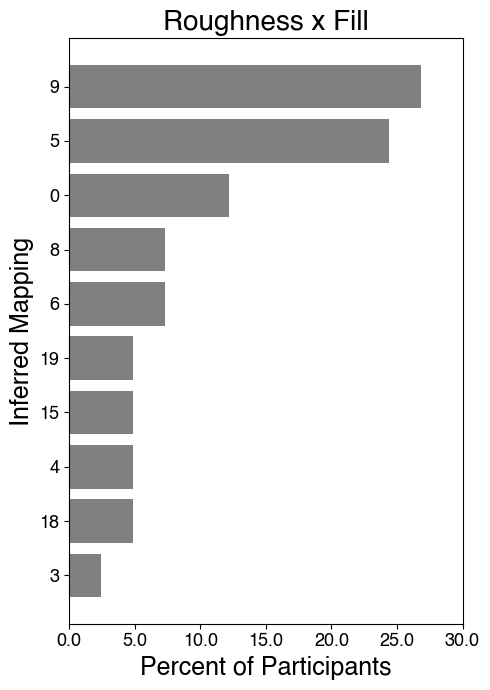

In [1331]:
# Count the number of occurrences of each value in assignmentID
counts = assignments_df_opcl['assignmentID'].value_counts()/assignments_df_opcl['assignmentID'].value_counts().sum()

# Sort the values in descending order
counts = counts.sort_values(ascending=True)

# Create the barplot
fig, ax = plt.subplots(figsize=(5, 7))
ax.barh(np.arange(len(counts)), counts.values, color='gray')

# Set the axis labels and title
ax.set_xlabel('Percent of Participants')
ax.set_ylabel('Inferred Mapping')
ax.set_title('Roughness x Fill', fontsize=20)
ax.set_yticks(range(len(counts)))
ax.set_yticklabels([str(x) for x in counts.index])
xticks= ax.get_xticks()
ax.set_xticklabels(np.round(xticks*100,4))
### increase the axes label size to 20
ax.tick_params(axis='both', which='major', labelsize=13)
### increase the x and y label size to 20 
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.set_xlim(0,.3)
plt.tight_layout()
plt.savefig('opcl_assignment_distribution.pdf')
plt.show()


/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_34651/3582224389.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(xticks*100,2))
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


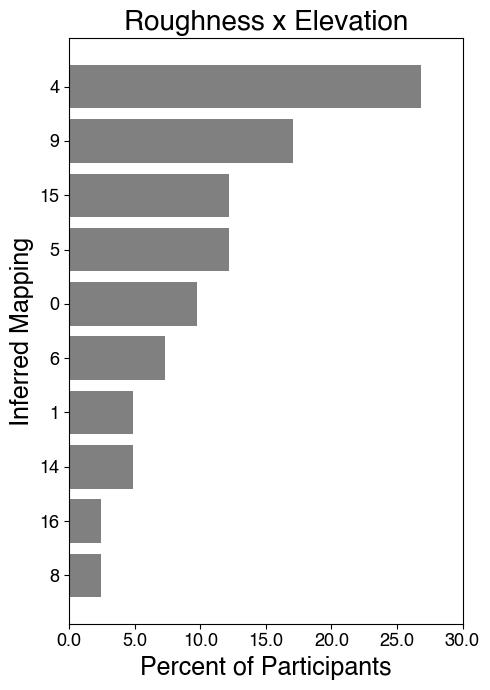

In [1332]:

# Count the number of occurrences of each value in assignmentID
counts = assignments_df_hilo['assignmentID'].value_counts()/assignments_df_hilo['assignmentID'].value_counts().sum()

# Sort the values in descending order
counts = counts.sort_values(ascending=True)

# Create the barplot
fig, ax = plt.subplots(figsize=(5, 7))
ax.barh(np.arange(len(counts)), counts.values, color='gray')

# Set the axis labels and title
ax.set_xlabel('Percent of Participants')
ax.set_ylabel('Inferred Mapping')
ax.set_title('Roughness x Elevation', fontsize=20)
ax.set_yticks(range(len(counts)))
ax.set_yticklabels([str(x) for x in counts.index])
xticks= ax.get_xticks()
ax.set_xticklabels(np.round(xticks*100,2))
### increase the axes label size to 20
ax.tick_params(axis='both', which='major', labelsize=13)
### increase the x and y label size to 20 
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.set_xlim(0,.3)
plt.tight_layout()
plt.savefig('hilo_assignment_distribution.pdf')
plt.show()


### get chi-square statistics


In [1358]:
opcl_strategy_counts = np.zeros(24)
valid_opcl_strategies = assignments_df_opcl.assignmentID.value_counts().index
opcl_strategy_counts[valid_opcl_strategies] = assignments_df_opcl.assignmentID.value_counts().values


compute_chisquare(opcl_strategy_counts)

Chi-square test statistic: 123.48780487804879
p-value: 9.771699927496258e-16


In [1359]:
hilo_strategy_counts = np.zeros(24)
valid_hilo_strategies = assignments_df_hilo.assignmentID.value_counts().index
hilo_strategy_counts[valid_hilo_strategies] = assignments_df_hilo.assignmentID.value_counts().values


compute_chisquare(hilo_strategy_counts)

Chi-square test statistic: 108.26829268292684
p-value: 5.094972835024989e-13
